This experiment looks at the effect of different kernel modes with the SVM alogithm when applied to NLP

First the leftover labels need to be merged with their most similar chosen label

In [1]:
LABEL_NUM = 28

label_names = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'
}

chosen_labels = [0, 1, 2, 3, 7, 10, 15, 17, 18, 20, 24, 25, 26]
chosen_label_names = []

for label in chosen_labels:
    chosen_label_names.append(label_names[label])

print("Chosen Labels:", chosen_label_names)

Chosen Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'curiosity', 'disapproval', 'gratitude', 'joy', 'love', 'optimism', 'remorse', 'sadness', 'surprise']


Get the dataset and create a matrix that describes the frequency of each label overlapping. This does not include the neutral label and relations of labels with themselves as this is useless information

In [2]:
import datasets
import torch
import matplotlib.pyplot as plt
emotions_dataset = datasets.load_dataset('go_emotions', split='train')
torch.manual_seed(56)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


In [201]:
relation_matrix = torch.zeros((LABEL_NUM,LABEL_NUM)).type(torch.int)

for row in emotions_dataset:
    labels = row['labels']
    for main_label in labels:
        for relation_label in labels:
            relation_matrix[main_label,relation_label] += 1

print(relation_matrix[:,:12])

tensor([[4130,   84,    5,   25,  246,   31,   24,   65,   33,   24,   14,   10],
        [  84, 2328,   15,   40,   57,    8,   24,   48,   10,   10,   20,    9],
        [   5,   15, 1567,  269,    8,    9,    8,   11,    4,   30,   43,   53],
        [  25,   40,  269, 2470,   37,   13,   24,   45,   12,  110,  178,   80],
        [ 246,   57,    8,   37, 2939,   65,   20,   36,   18,   23,   19,   13],
        [  31,    8,    9,   13,   65, 1087,    1,   15,   11,   10,   14,    2],
        [  24,   24,    8,   24,   20,    1, 1368,  212,    2,   16,   22,    3],
        [  65,   48,   11,   45,   36,   15,  212, 2191,   11,   21,   31,   11],
        [  33,   10,    4,   12,   18,   11,    2,   11,  641,   12,    5,    3],
        [  24,   10,   30,  110,   23,   10,   16,   21,   12, 1269,   54,   20],
        [  14,   20,   43,  178,   19,   14,   22,   31,    5,   54, 2022,   36],
        [  10,    9,   53,   80,   13,    2,    3,   11,    3,   20,   36,  793],
        [   3,  

Next create a mask to remove relations of unchosen labels to other unchosen labels. This means when we chose what labels to merge we will end up with only chosen labels left

In [202]:
mask1 = torch.ones((LABEL_NUM,LABEL_NUM)).type(torch.int)
mask2 = torch.ones((LABEL_NUM,LABEL_NUM)).type(torch.int)
mask3 = torch.ones((LABEL_NUM,LABEL_NUM)).type(torch.int)

unchosen_labels = list(range(LABEL_NUM))

for label in chosen_labels:
    unchosen_labels.remove(label)

for label in unchosen_labels:
    mask2[:, label].fill_(0.0)

for i in range(LABEL_NUM):
    mask1[i,i] = 0.0

mask3[LABEL_NUM-1].fill_(0.0)
mask3[:,LABEL_NUM-1].fill_(0.0)

print(mask1[:10,:10])
print(mask2[:10,:10])
print(mask3[-10:,-10:])

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=torch.int32)
tensor([[1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0]], dtype=torch.int32)
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],


Apply mask to relation matrix and find which unchosen labels should merge to which chosen labels

In [203]:
relation_matrix = relation_matrix * mask1

row_sum = relation_matrix.sum(dim=1)
for i in range(LABEL_NUM-1):
    if row_sum[i] == 0:
        relation_matrix[i].fill_(1.0)

relation_matrix = relation_matrix * mask2

print(relation_matrix[:,:10])
r_norm = relation_matrix.sum(dim=1).reshape(-1, 1)

print(r_norm)
relation_matrix = relation_matrix / r_norm
print(relation_matrix[:,:10])

tensor([[  0,  84,   5,  25,   0,   0,   0,  65,   0,   0],
        [ 84,   0,  15,  40,   0,   0,   0,  48,   0,   0],
        [  5,  15,   0, 269,   0,   0,   0,  11,   0,   0],
        [ 25,  40, 269,   0,   0,   0,   0,  45,   0,   0],
        [246,  57,   8,  37,   0,   0,   0,  36,   0,   0],
        [ 31,   8,   9,  13,   0,   0,   0,  15,   0,   0],
        [ 24,  24,   8,  24,   0,   0,   0, 212,   0,   0],
        [ 65,  48,  11,  45,   0,   0,   0,   0,   0,   0],
        [ 33,  10,   4,  12,   0,   0,   0,  11,   0,   0],
        [ 24,  10,  30, 110,   0,   0,   0,  21,   0,   0],
        [ 14,  20,  43, 178,   0,   0,   0,  31,   0,   0],
        [ 10,   9,  53,  80,   0,   0,   0,  11,   0,   0],
        [  3,   8,   6,   9,   0,   0,   0,  10,   0,   0],
        [ 75,  13,   0,   4,   0,   0,   0,  21,   0,   0],
        [ 14,   3,   5,  11,   0,   0,   0,  11,   0,   0],
        [279,  82,  11,  20,   0,   0,   0,  31,   0,   0],
        [  1,   0,   0,   2,   0,   0,  

In [204]:
label_mergers = dict()
for label in unchosen_labels:
    label_mergers[label] = torch.argmax(relation_matrix[label]).item()
for label in chosen_labels:
    label_mergers[label] = label
label_mergers[27] = 27

label_merger_names = dict()
for key, value in label_mergers.items():
    label_merger_names[label_names[key]] = label_names[value]

print(label_merger_names)

{'approval': 'admiration', 'caring': 'optimism', 'confusion': 'curiosity', 'desire': 'optimism', 'disappointment': 'sadness', 'disgust': 'annoyance', 'embarrassment': 'sadness', 'excitement': 'joy', 'fear': 'sadness', 'grief': 'sadness', 'nervousness': 'sadness', 'pride': 'admiration', 'realization': 'admiration', 'relief': 'gratitude', 'neutral': 'neutral', 'admiration': 'admiration', 'amusement': 'amusement', 'anger': 'anger', 'annoyance': 'annoyance', 'curiosity': 'curiosity', 'disapproval': 'disapproval', 'gratitude': 'gratitude', 'joy': 'joy', 'love': 'love', 'optimism': 'optimism', 'remorse': 'remorse', 'sadness': 'sadness', 'surprise': 'surprise'}


Next we apply the merging

{0: 4130, 1: 2328, 2: 1567, 3: 2470, 7: 2191, 10: 2022, 15: 2662, 17: 1452, 18: 2086, 20: 1581, 24: 545, 25: 1326, 26: 1060, 27: 14219}
tensor(2831.3572)
tensor(3386.5576)


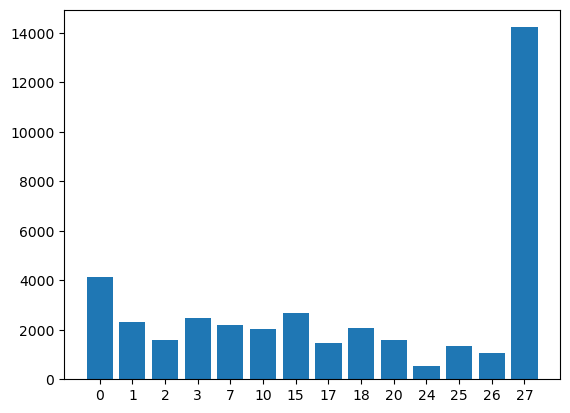

In [205]:
label_occurances = dict()
for label in chosen_labels:
    label_occurances[label] = 0
label_occurances[27] = 0

for row in emotions_dataset:
    for label in row['labels']:
        if label in chosen_labels or label == 27:
            label_occurances[label] += 1

print(label_occurances)

occurances = torch.tensor(list(label_occurances.values())).type(torch.float)
print(torch.mean(occurances))
print(torch.std(occurances))

plt.bar(x=list(map(str, label_occurances.keys())), height=list(label_occurances.values()))
plt.show()

In [206]:
# merged_labels = []
# for i in range(len(emotions_dataset)):
#     new_labels = emotions_dataset[i]['labels']
#     for i in range(len(new_labels)):
#         new_labels[i] = label_mergers[new_labels[i]]

#     new_labels = list(set(new_labels))
#     merged_labels.append(new_labels)

In [207]:
def split_valid_labels(labels):
    valid = []
    invalid = []

    for label in labels:
        if label in chosen_labels or label == 27:
            valid.append(label)
        else:
            invalid.append(label)
    return valid, invalid

def get_merged_label(label, valid_labels):
    if LABEL_NUM-1 in valid_labels:
        valid_labels.remove(LABEL_NUM-1)
    if len(valid_labels) > 0:
        probs = relation_matrix[label, valid_labels]
    else:
        probs = relation_matrix[label]
        valid_labels = list(range(probs.shape[0]))
    probs = (probs / probs.sum()).cumsum(dim=0)

    p = torch.rand(1)
    indx = torch.searchsorted(probs, p)
    return valid_labels[indx]

There are still multiple labels for some of the inputs so we need to chose only one label per input. This is done by trying to maximise the distrubution of all labels for a more even dataset.

In [208]:
merged_labels = []
label_occurances = dict()
for label in chosen_labels:
    label_occurances[label] = 0
label_occurances[27] = 0

for i in range(len(emotions_dataset)):
    labels = emotions_dataset[i]['labels']
    valid, invalid = split_valid_labels(labels)

    for i in range(len(invalid)):
        invalid[i] = get_merged_label(invalid[i], valid)

    valid.extend(invalid)
    labels = list(set(valid))

    merged_labels.append(labels)

for i in range(len(merged_labels)):
    min_label = merged_labels[i][0]
    for j in range(len(merged_labels[i])):
        if label_occurances[merged_labels[i][j]] < label_occurances[min_label]:
            min_label = merged_labels[i][j]

    label_occurances[min_label] += 1
    merged_labels[i] = min_label

occurances = torch.tensor(list(label_occurances.values())).type(torch.float)
print(torch.mean(occurances))
print(torch.std(occurances))
print(label_occurances)
print(merged_labels)



tensor(3100.7144)
tensor(2924.0332)
{0: 4513, 1: 2567, 2: 1906, 3: 2703, 7: 2835, 10: 2384, 15: 2817, 17: 1970, 18: 2448, 20: 2403, 24: 740, 25: 1902, 26: 1399, 27: 12823}
[27, 27, 2, 26, 3, 26, 15, 20, 0, 27, 7, 1, 27, 18, 3, 3, 15, 2, 27, 10, 10, 2, 27, 27, 27, 2, 27, 25, 15, 27, 2, 7, 27, 7, 7, 17, 27, 0, 25, 27, 0, 18, 25, 27, 7, 10, 20, 27, 27, 27, 27, 27, 15, 27, 15, 10, 27, 27, 27, 15, 1, 3, 27, 7, 27, 0, 27, 1, 27, 0, 27, 0, 3, 27, 27, 27, 0, 0, 27, 1, 0, 0, 25, 10, 27, 25, 15, 3, 20, 27, 18, 27, 24, 18, 0, 27, 7, 27, 7, 27, 0, 3, 10, 27, 27, 20, 27, 7, 27, 15, 27, 0, 15, 27, 17, 27, 2, 2, 27, 27, 0, 20, 27, 3, 2, 26, 7, 2, 27, 17, 15, 27, 2, 27, 27, 10, 15, 18, 27, 2, 26, 17, 27, 27, 18, 25, 15, 1, 1, 1, 1, 15, 18, 10, 27, 27, 0, 0, 18, 27, 15, 27, 3, 27, 25, 27, 0, 27, 25, 7, 18, 27, 20, 27, 27, 0, 27, 0, 17, 27, 26, 7, 15, 26, 0, 10, 27, 17, 27, 7, 0, 2, 3, 20, 15, 27, 27, 10, 27, 18, 27, 7, 7, 25, 17, 10, 27, 15, 0, 27, 0, 18, 27, 7, 27, 26, 27, 26, 27, 25, 0, 15, 25, 18, 0

Plotting the distribution we can see which labels are more common than others

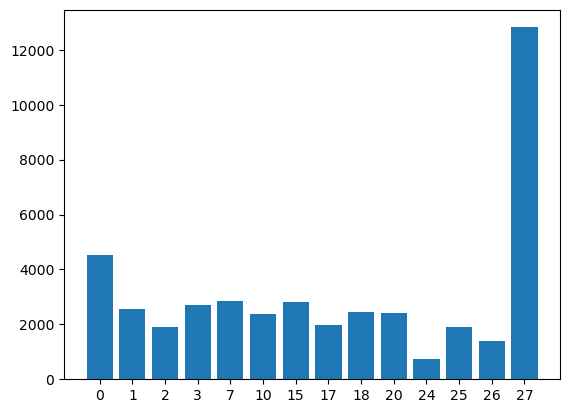

In [209]:
plt.bar(x=list(map(str, label_occurances.keys())), height=list(label_occurances.values()))
plt.show()

In [210]:
merged_labels = torch.tensor(merged_labels, dtype=int)
torch.save({
    'labels': merged_labels 
}, './data/new_labels.pt')